In [1]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import mplleaflet, pydotplus
from math import radians, cos, sin, asin, sqrt
from ibmgeohashpy import geohash
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import ListedColormap
import os, sys, json, re, itertools, warnings, folium
from matplotlib import animation
from IPython.display import Image
%matplotlib inline
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
print('Libraries imported..')

Libraries imported..


In [2]:
# Setup a Spark instance from Anaconda Python framework through the interface PySpark
# Use Machine Learning Library MLLib from Pyspark
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.append(spark_home + "/python")
sys.path.append(os.path.join(spark_home, 'python/lib/py4j-0.9-src.zip'))

filename = os.path.join(spark_home, 'python/pyspark/shell.py')
exec(compile(open(filename, "rb").read(), filename, 'exec'))

from pyspark.mllib.fpm import FPGrowth
from pyspark.mllib.clustering import KMeans

print('Spark instance running..')

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/

Using Python version 3.5.2 (default, Jul  2 2016 17:53:06)
SparkContext available as sc, HiveContext available as sqlContext.
Spark instance running..


In [53]:
train = pd.read_csv('data/gender_age_train.csv')
events_within_china = pd.read_csv('./data/events_within_china.csv')
data = events_within_china.merge(train, on = 'device_id', how = 'inner')
# Remove NA from data
data = data.dropna(how='any').drop_duplicates()
print (data.shape)
print (data.columns)

(829216, 9)
Index(['Unnamed: 0', 'event_id', 'device_id', 'timestamp', 'longitude',
       'latitude', 'gender', 'age', 'group'],
      dtype='object')


In [54]:
data.head()

,Unnamed: 0,event_id,device_id,timestamp,longitude,latitude,gender,age,group
0,0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,M,46,M39+
1,7103,7104,29182687948017175,2016-05-02 09:37:02,121.38,31.24,M,46,M39+
2,29660,29661,29182687948017175,2016-05-04 00:56:04,121.39,31.23,M,46,M39+
3,33132,33133,29182687948017175,2016-05-06 05:01:15,121.38,31.24,M,46,M39+
4,38979,38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,M,46,M39+


In [57]:
geohashes=[]
for x,y in zip(data.latitude,data.longitude):
    geohashes.append(geohash.encode(x,y,6))
data['geohash_6'] = geohashes
data = data[['device_id','gender','age','group','geohash_6','event_id']]
data.to_csv('gender_age_train_data_geohash_6_05022017.txt', sep=' ', index=False, header=False)
data.head()

,device_id,gender,age,group,geohash_6,event_id
0,29182687948017175,M,46,M39+,wtw3dp,1
1,29182687948017175,M,46,M39+,wtw3dp,7104
2,29182687948017175,M,46,M39+,wtw3dm,29661
3,29182687948017175,M,46,M39+,wtw3dp,33133
4,29182687948017175,M,46,M39+,wtw0m5,38980


In [58]:
data.shape

(829216, 6)

In [59]:
# Create training dataset with a format that FPGrowthModel understands
rdd = sc.textFile("gender_age_train_data_geohash_6_05022017.txt")
transactions = rdd.map(lambda line: line.strip().split(' '))
unique = transactions.map(lambda x: list(set(x))).cache()
print('Generating RDD in Spark for obtaining Frequent itemsets....')

Generating RDD in Spark for obtaining Frequent itemsets....


In [77]:
numpart,minsup,validfreq = [],[],[]
for i in np.arange(2,6,2):
    for j in np.arange(0.00002,0.00015,0.00001):
        model = FPGrowth.train(unique, minSupport=j, numPartitions=i)
        result = model.freqItemsets().collect()
        filename = 'freqItemSets_train_data_05022017_ms_0_0000'+str(int(j*100000))+'_np_'+str(i)+'.txt'
        outfile = open(filename, 'w')
        for item in result:
            outfile.write("%s\n" % str(item))
        #print('Generating freqitemsets for min_support='+str(j)+'no_of_partitions='+str(i)+'..')    
        text_file = open(filename, "r")
        freqitems = text_file.read().split('\n')
        validitems = []
        for item in freqitems:
            if len(item)>73:
                validitems.append(item)
        print('Total no of valid frequent itemsets for min_support:'+str(j)+' and '+str(i)+' partitions= '+str(len(validitems)))
        numpart.append(i)
        minsup.append(j)
        validfreq.append(len(validitems))
        freqsets = []
        for item in validitems:
            # if the string matches the word 'freq' pick the value starting from '=' until ')'
            x = re.search("freq", item).end()
            # convert the extracted value to a number and check if it is > 50
            item1 = int(item[x+1:len(item)-1])
            #print(item1)
            if item1>50:
                freqsets.append(item)
        newitems = []
        for item in freqsets:
            x = int(re.search("]",item).start())
            group = item[19:x]
            freq = item[x+8:len(item)-1]
            newitem = group + ', ' + freq
            newitems.append(newitem)
        filename1 = 'formatted_'+filename
        outfile1 = open(filename1, 'w')
        for item in newitems:
            if len(item)>53: #63 for 12-char geohash
                outfile1.write("%s\n" % str(item))
        outfile1.close() 
        filepath1 = 'formatted_freqItemSets_train_data_05022017_ms_0_0000'+str(int(j*100000))+'_np_'+str(i)+'.txt'
        df = pd.read_csv(filepath1, header = None)
        df1 = df
        df1[0] = df1[0].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1[1] = df1[1].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1[2] = df1[2].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1[3]= df1[3].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1[4]= df1[4].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1.columns = ['geohashes','device_id','age','group','gender','freq']
        for item in range(0,len(df1)):
            if len(df1.iloc[item,0])>15:
                #print('\n',df1.iloc[i,0])
                a = df1.iloc[item,0]
                b = df1.iloc[item,1]
                df1.iloc[item,0] = b
                df1.iloc[item,1] = a
            if len(df1.iloc[item,2])>2:
                #print('\n',df1.iloc[i,0])
                a1 = df1.iloc[item,2]
                b1 = df1.iloc[item,3]
                df1.iloc[item,2] = b1
                df1.iloc[item,3] = a1
        #Convert the age and device_id columns to integer type and sort by frequency
        df1['age'] = df1['age'].map(lambda x: int(x))
        df1['device_id'] = df1['device_id'].map(lambda x: int(x))
        df1 = df1.sort_values(by = 'freq', inplace = False, axis = 0, ascending= False)
        # Assign numeric values to gender M := 0 and F := 1
        for k in range(0,len(df1)):
            if df1.iloc[k,4] == 'M':
                df1.iloc[k,4] = 0
            else:
                df1.iloc[k,4] = 1
        #Assign numeric values to groups
        #print('\nUnique Groups : \n\n M22-: 1, M23-26 : 2, M27-28: 3, M29-31: 4, M32-38: 5, M39+: 6')
        #print('\n F23-: 7, F24-26 : 8, F27-28: 9, F29-32: 10, F33-42: 11, F43+: 12 ')
        for i1 in range(0,len(df1)):
            if df1.iloc[i1,3] == 'M22-':
                df1.iloc[i1,3] = 1
            elif df1.iloc[i1,3] == 'M23-26':
                df1.iloc[i1,3] = 2
            elif df1.iloc[i1,3] == 'M27-28':
                df1.iloc[i1,3] = 3
            elif df1.iloc[i1,3] == 'M29-31':
                df1.iloc[i1,3] = 4
            elif df1.iloc[i1,3] == 'M32-38':
                df1.iloc[i1,3] = 5
            elif df1.iloc[i1,3] == 'M39+':
                df1.iloc[i1,3] = 6
            elif df1.iloc[i1,3] == 'F23-':
                df1.iloc[i1,3] = 7
            elif df1.iloc[i1,3] == 'F24-26':
                df1.iloc[i1,3] = 8
            elif df1.iloc[i1,3] == 'F27-28':
                df1.iloc[i1,3] = 9
            elif df1.iloc[i1,3] == 'F29-32':
                df1.iloc[i1,3] = 10
            elif df1.iloc[i1,3] == 'F33-42':
                df1.iloc[i1,3] = 11
            elif df1.iloc[i1,3] == 'F43+':
                df1.iloc[i1,3] = 12
        filepath2 = 'formatted_'+filepath1[28:-4]+'.csv'
        df1.to_csv(filepath2, index = False)
        print('Created formatted freq-itemset..')

Total no of valid frequent itemsets for min_support:2e-05 and 2 partitions= 27987


ValueError: invalid literal for int() with base 10: 'M39+'

In [78]:
for i in range(0,len(df)):
    if len(df.iloc[i,2])!=2:
        print(i)

413
483
1314
1397
1510
1643
1650
1857
1897
2462
2582
2789
3171
3607


In [76]:
df.to_csv('formatted_freqItemSets_train_data_05022017_ms_0_00002_np_2.txt')

In [11]:
# For those items in the freqitemsets where device_id comes before geohash, swap the values
for i in np.arange(2,10,2):
    for j in np.arange(0.00002,0.00013,0.00001):
        filepath1 = 'formatted_freqItemSets_train_data_05022017_ms_0_0000'+str(j*100000)+'_np_'+str(i)+'.txt'
        df = pd.read_csv(filepath1, header = None)
        df1 = df   
        # print('Creating a pandas dataframe using the frequently occurring geohashes..')
        # print('\n Number of frequent itemsets :',df1.shape[0],'\n')
        #Format the string by removing extra spaces and quotes
        df1[0] = df1[0].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1[1] = df1[1].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1[2] = df1[2].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1[3]= df1[3].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1[4]= df1[4].map(lambda x: x.lstrip(' \'').rstrip('\''))
        df1.columns = ['geohashes','device_id','age','group','gender','freq']

        #print(df1.head())
        #print('\nRearranging data correctly from frequent itemsets..')
        # Reshuffle geohash, device_id and age,group columns to synchronise the data
        for item in range(0,len(df1)):
            if len(df1.iloc[item,0])>15:
                #print('\n',df1.iloc[i,0])
                a = df1.iloc[item,0]
                b = df1.iloc[item,1]
                df1.iloc[item,0] = b
                df1.iloc[item,1] = a
            if len(df1.iloc[item,2])>2:
                #print('\n',df1.iloc[i,0])
                a1 = df1.iloc[item,2]
                b1 = df1.iloc[item,3]
                df1.iloc[item,2] = b1
                df1.iloc[item,3] = a1

        #print('\nReshuffling complete..')

        #Convert the age and device_id columns to integer type and sort by frequency
        df1['age'] = df1['age'].map(lambda x: int(x))
        df1['device_id'] = df1['device_id'].map(lambda x: int(x))
        df1 = df1.sort_values(by = 'freq', inplace = False, axis = 0, ascending= False)
        #print('\nConverting categorical values to numeric values for further analyses.\n \nMale=0 & Female =1')
        # Assign numeric values to gender M := 0 and F := 1
        for k in range(0,len(df1)):
            if df1.iloc[k,4] == 'M':
                df1.iloc[k,4] = 0
            else:
                df1.iloc[k,4] = 1

        #Assign numeric values to groups
        #print('\nUnique Groups : \n\n M22-: 1, M23-26 : 2, M27-28: 3, M29-31: 4, M32-38: 5, M39+: 6')
        #print('\n F23-: 7, F24-26 : 8, F27-28: 9, F29-32: 10, F33-42: 11, F43+: 12 ')
        for i1 in range(0,len(df1)):
            if df1.iloc[i1,3] == 'M22-':
                df1.iloc[i1,3] = 1
            elif df1.iloc[i1,3] == 'M23-26':
                df1.iloc[i1,3] = 2
            elif df1.iloc[i1,3] == 'M27-28':
                df1.iloc[i1,3] = 3
            elif df1.iloc[i1,3] == 'M29-31':
                df1.iloc[i1,3] = 4
            elif df1.iloc[i1,3] == 'M32-38':
                df1.iloc[i1,3] = 5
            elif df1.iloc[i1,3] == 'M39+':
                df1.iloc[i1,3] = 6
            elif df1.iloc[i1,3] == 'F23-':
                df1.iloc[i1,3] = 7
            elif df1.iloc[i1,3] == 'F24-26':
                df1.iloc[i1,3] = 8
            elif df1.iloc[i1,3] == 'F27-28':
                df1.iloc[i1,3] = 9
            elif df1.iloc[i1,3] == 'F29-32':
                df1.iloc[i1,3] = 10
            elif df1.iloc[i1,3] == 'F33-42':
                df1.iloc[i1,3] = 11
            elif df1.iloc[i1,3] == 'F43+':
                df1.iloc[i1,3] = 12
        filepath2 = 'formatted_'+filepath1[28:-4]+'.csv'
        df1.to_csv(filepath2, index = False)
        print(filepath2)

formatted__data_02022017_ms_0_00002.0_np_2.csv
formatted__data_02022017_ms_0_00003.0_np_2.csv
formatted__data_02022017_ms_0_00004.0_np_2.csv
formatted__data_02022017_ms_0_00005.0_np_2.csv
formatted__data_02022017_ms_0_00006.0_np_2.csv
formatted__data_02022017_ms_0_00007.0_np_2.csv
formatted__data_02022017_ms_0_00008.0_np_2.csv
formatted__data_02022017_ms_0_00009.0_np_2.csv
formatted__data_02022017_ms_0_000010.0_np_2.csv
formatted__data_02022017_ms_0_000011.0_np_2.csv
formatted__data_02022017_ms_0_000012.0_np_2.csv
formatted__data_02022017_ms_0_00002.0_np_3.csv
formatted__data_02022017_ms_0_00003.0_np_3.csv
formatted__data_02022017_ms_0_00004.0_np_3.csv
formatted__data_02022017_ms_0_00005.0_np_3.csv
formatted__data_02022017_ms_0_00006.0_np_3.csv
formatted__data_02022017_ms_0_00007.0_np_3.csv
formatted__data_02022017_ms_0_00008.0_np_3.csv
formatted__data_02022017_ms_0_00009.0_np_3.csv
formatted__data_02022017_ms_0_000010.0_np_3.csv
formatted__data_02022017_ms_0_000011.0_np_3.csv
formatte

In [ ]:
numpart

In [27]:
df_fpg = pd.read_csv('formatted__data_02022017_ms_0_000012.0_np_4.csv')
df_fpg.head()

,geohashes,device_id,age,group,gender,freq
0,wqptdu1xjj2s,-8340098378141155823,28,3,0,3745
1,wt3mbj1e4vp1,1779631023439405334,39,11,1,2233
2,wwc2kg4sb3f6,4782582047729166353,36,5,0,2126
3,wtb59r7wyjg5,5098778421671837341,38,5,0,2003
4,wqj5yccx13h1,3074308677943390456,24,2,0,1491


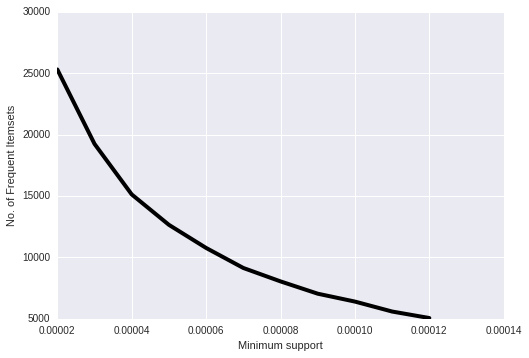

In [28]:
import numpy as np
import seaborn as sb
numpartition = 4
freqsets1 = [25310,19258,15130,12650,10771,9135,8045,7045,6398,5594,5059]
freqsets2 = [25310,19246,15130,12653,10771,9140,8047,7045,6403,5592,5063]
minsup =  np.arange(0.00002,0.00013,0.00001)
#plt.plot(minsup,freqsets1,color='k',lw=2)  
plt.plot(minsup,freqsets2,color='k',lw=4)
plt.xlabel('Minimum support')
plt.ylabel('No. of Frequent Itemsets')
#plt.title('# of Frequent geohashes v/s minsupport for FPGrowth Model')
plt.show()